In [58]:
import numpy as np
from qokit.portfolio_optimization import get_problem
from qokit.portfolio_optimization import portfolio_brute_force, get_sk_ini
from qokit.qaoa_objective_portfolio import get_qaoa_portfolio_objective
from scipy.optimize import minimize
import nlopt
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['text.usetex'] = False

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

plt.rcParams['figure.dpi']=500

def minimize_nlopt(f, x0, rhobeg=None, p=None, cd=False, ad=True):
    def nlopt_wrapper(x, grad):
        if grad.size > 0:
            sys.exit("Shouldn't be calling a gradient!")
        return f(x).real
    num_parameters = 0
    if ad:
        num_parameters = 2*p
    if cd:
        num_parameters += p

    opt = nlopt.opt(nlopt.LN_BOBYQA, num_parameters)
    opt.set_min_objective(nlopt_wrapper)

    opt.set_xtol_rel(1e-8)
    opt.set_ftol_rel(1e-8)
    opt.set_initial_step(rhobeg)
    xstar = opt.optimize(x0)
    minf = opt.last_optimum_value()

    return xstar, minf


In [2]:
po_problem = get_problem(N=6,K=3,q=0.5,seed=1,pre=1)
means_in_spins = np.array([po_problem['means'][i] - po_problem['q'] * np.sum(po_problem['cov'][i, :]) for i in range(len(po_problem['means']))])
scale = 1 / (np.sqrt(np.mean((( po_problem['q']*po_problem['cov'])**2).flatten()))+np.sqrt(np.mean((means_in_spins**2).flatten())))

po_problem = get_problem(N=6,K=3,q=0.5,seed=1,pre=scale)

p_qaoa = [1,2,3,4]
p_cd_qaoa = [1,2,3]
p_cd = [1,2,3,4,5]


#qaoa_obj = get_qaoa_portfolio_objective(po_problem=po_problem,p=p,ini='dicke',mixer='trotter_ring',T=1,simulator='python')

best_portfolio = portfolio_brute_force(po_problem,return_bitstring=False)

#x0 = get_sk_ini(p=p) 

ar_jpm = []
ar_jpm_kipu = []
ar_kipu = []


In [20]:
for p in [2]:

    qaoa_obj_qiskit = get_qaoa_portfolio_objective(po_problem=po_problem,p=p,ini='dicke',mixer='trotter_ring',T=1,simulator='qiskit',cd=False)    
    _ar_jpm = []

    for _ in tqdm(range(100)):
        x0 = 2*np.pi*np.random.rand(2*p)

        _, opt_energy = minimize_nlopt(qaoa_obj_qiskit, x0, p=p, rhobeg=0.01, cd=False)
        opt_ar = (opt_energy-best_portfolio[1])/(best_portfolio[0]-best_portfolio[1])

        _ar_jpm.append(opt_ar)

    print(np.max(_ar_jpm))
    ar_jpm.append(np.max(_ar_jpm))

100%|██████████| 100/100 [05:47<00:00,  3.48s/it]

0.860187423635198


In [27]:
ar_jpm = [0.8347241354092791,
 0.8601874210203008,
 0.9074357082329172,
 0.9284820395685935]

In [22]:
for p in [1]:

    qaoa_obj_qiskit = get_qaoa_portfolio_objective(po_problem=po_problem,p=p,ini='dicke',mixer='trotter_ring',T=1,simulator='qiskit',cd=True)    
    _ar_jpm_kipu = []

    for _ in tqdm(range(100)):
        
        x0 = 2*np.pi*np.random.rand(3*p)

        _, opt_energy = minimize_nlopt(qaoa_obj_qiskit, x0, p=p, rhobeg=0.01, cd=True)
        opt_ar = (opt_energy-best_portfolio[1])/(best_portfolio[0]-best_portfolio[1])

        _ar_jpm_kipu.append(opt_ar)

    print(np.max(_ar_jpm_kipu))
    ar_jpm_kipu.append(np.max(_ar_jpm_kipu))

100%|██████████| 100/100 [01:56<00:00,  1.16s/it]

0.8588584850880299


In [28]:
ar_jpm_kipu = [0.8588584850880299, 0.9275331469644188, 0.949870369093413]

In [36]:
for p in [5]:

    qaoa_obj_qiskit = get_qaoa_portfolio_objective(po_problem=po_problem,p=p,ini='dicke',mixer='trotter_ring',T=1,simulator='qiskit',cd=True,ad=False)    
    _ar_kipu = []

    for _ in tqdm(range(100)):
        
        x0 = 2*np.pi*np.random.rand(p)

        _, opt_energy = minimize_nlopt(qaoa_obj_qiskit, x0, p=p, rhobeg=0.01, cd=True, ad=False)
        opt_ar = (opt_energy-best_portfolio[1])/(best_portfolio[0]-best_portfolio[1])

        _ar_kipu.append(opt_ar)

    print(np.max(_ar_kipu))
    ar_kipu.append(np.max(_ar_kipu))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [11:10<00:00,  6.71s/it]

0.9566929145409342


In [37]:
ar_kipu = [0.8324937901324726,
 0.8512694985989354,
 0.9158203147956705,
 0.9410974860806302,
 0.9566929145409342]

In [44]:
labels_qaoa = [2,4,6,8]
labels_cd_qaoa = [3,6,9]
labels_cd = [1,2,3,4,5]

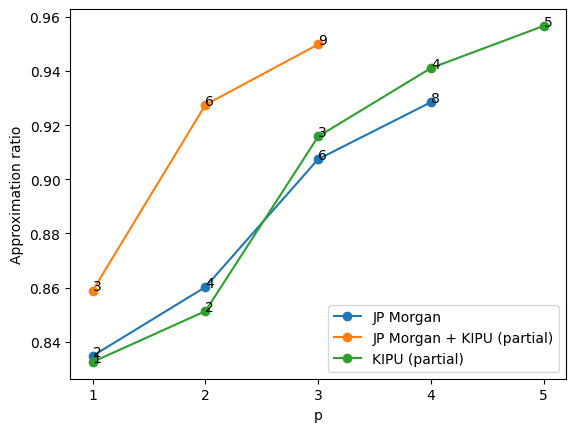

In [45]:
fig, ax = plt.subplots()


ax.plot(p_qaoa, ar_jpm, '-o', label="JP Morgan")
ax.plot(p_cd_qaoa, ar_jpm_kipu, '-o', label="JP Morgan + KIPU (partial)")
ax.plot(p_cd, ar_kipu, '-o', label="KIPU (partial)")


for i, txt in enumerate(labels_qaoa):
    ax.annotate(txt, (p_qaoa[i], ar_jpm[i]))
for i, txt in enumerate(labels_cd_qaoa):
    ax.annotate(txt, (p_cd_qaoa[i], ar_jpm_kipu[i])) 
for i, txt in enumerate(labels_cd):
    ax.annotate(txt, (p_cd[i], ar_kipu[i]))        

ax.set_xticks([1,2,3,4,5])
ax.set_xlabel("p")
ax.set_ylabel("Approximation ratio")
ax.legend()

In [40]:
mixer_depth = 2
cost_depth = 5

labels_qaoa = [cost_depth + mixer_depth,2*(cost_depth + mixer_depth),3*(cost_depth + mixer_depth),4*(cost_depth + mixer_depth)]
labels_cd_qaoa = [cost_depth + 2*mixer_depth,2*(cost_depth + 2*mixer_depth),3*(cost_depth + 2*mixer_depth)]
labels_cd = [mixer_depth,2*mixer_depth,3*mixer_depth,4*mixer_depth,5*mixer_depth]

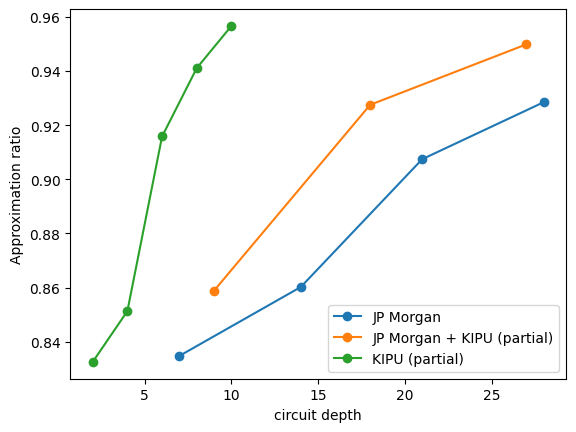

In [42]:
fig, ax = plt.subplots()


ax.plot(labels_qaoa, ar_jpm, '-o', label="JP Morgan")
ax.plot(labels_cd_qaoa, ar_jpm_kipu, '-o', label="JP Morgan + KIPU (partial)")
ax.plot(labels_cd, ar_kipu, '-o', label="KIPU (partial)")       

ax.set_xlabel("circuit gates")
ax.set_ylabel("Approximation ratio")
ax.legend()

In [48]:
mixer_gates = 2*(5)
cost_gates = 6*(6-1)//2

labels_qaoa = [cost_gates + mixer_gates,2*(cost_gates + mixer_gates),3*(cost_gates + mixer_gates),4*(cost_gates + mixer_gates)]
labels_cd_qaoa = [cost_gates + 2*mixer_gates,2*(cost_gates + 2*mixer_gates),3*(cost_gates + 2*mixer_gates)]
labels_cd = [mixer_gates,2*mixer_gates,3*mixer_gates,4*mixer_gates,5*mixer_gates]

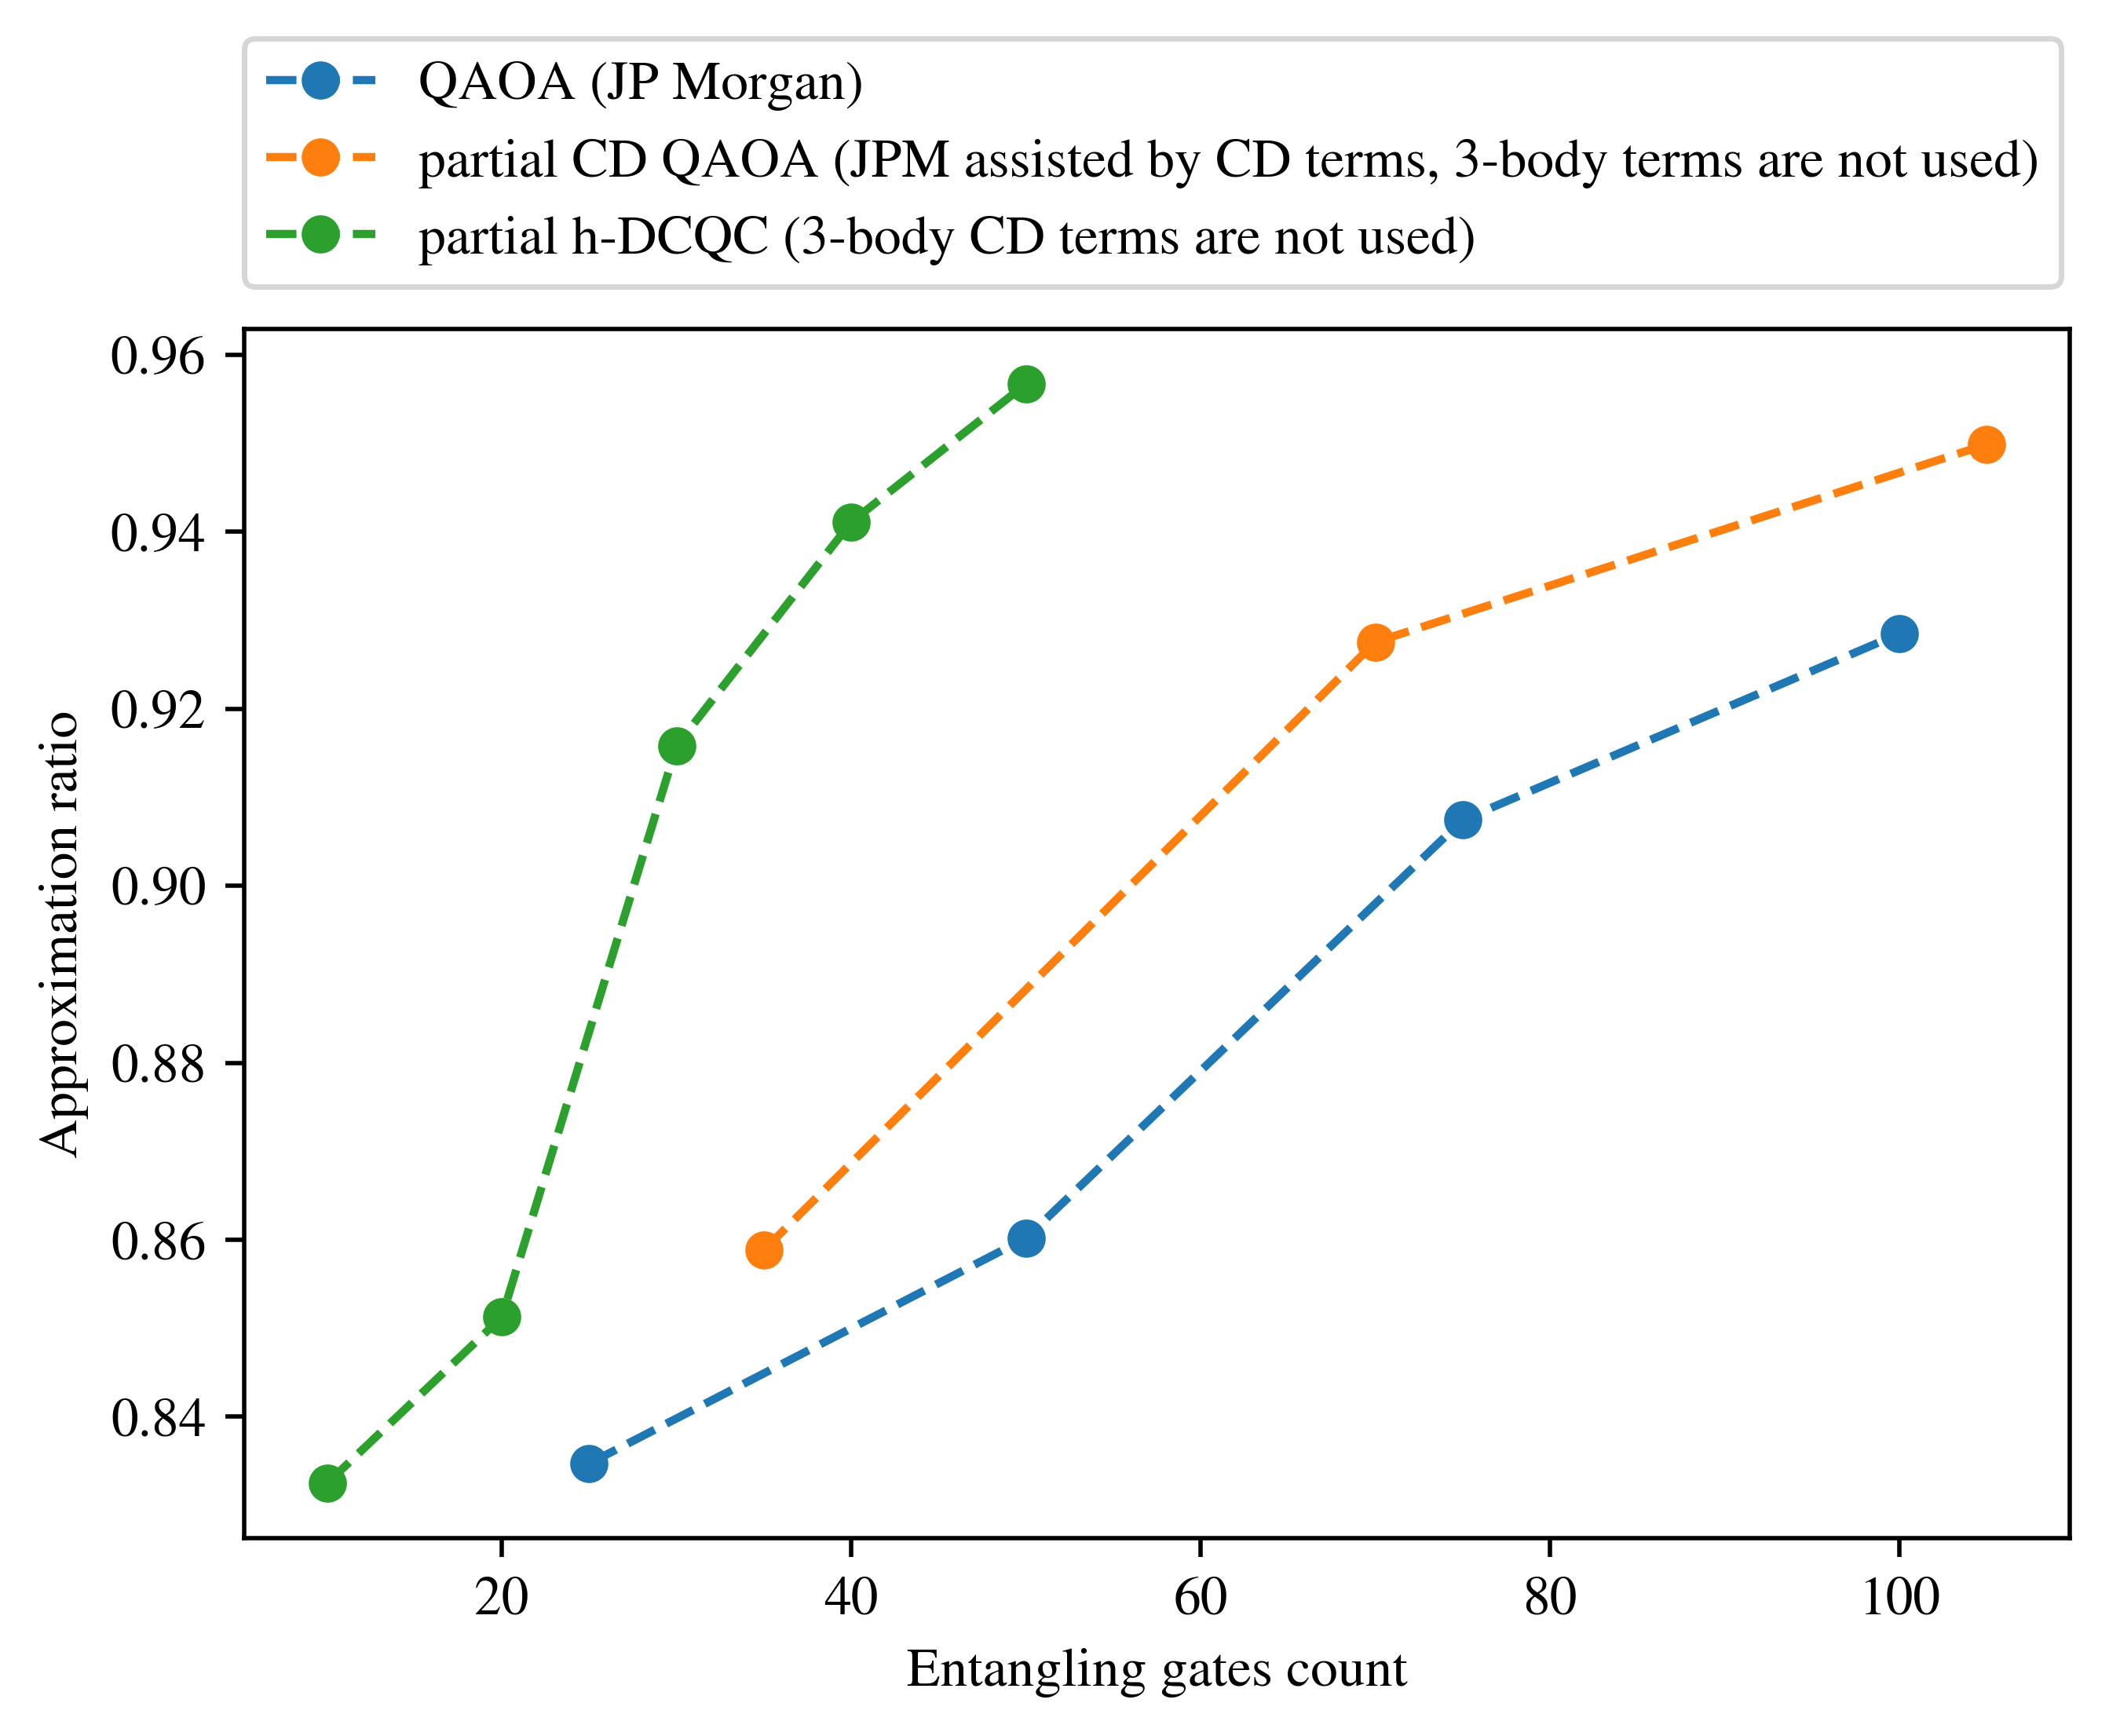

In [164]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(labels_qaoa, ar_jpm, '--o', label="QAOA (JP Morgan)")
ax.plot(labels_cd_qaoa, ar_jpm_kipu, '--o', label="partial CD QAOA (JPM assisted by CD terms, 3-body terms are not used)")
ax.plot(labels_cd, ar_kipu, '--o', label="partial h-DCQC (3-body CD terms are not used)")      

ax.set_xlabel("Entangling gates count")
ax.set_ylabel("Approximation ratio")
ax.legend( loc=2, ncol=1,bbox_to_anchor=(0., 1.1, 1., .14),borderaxespad=0.)

#ax.text(0, 0.73, '6 qubit instance \n\nEach point in the plots corresponds to a different $p$(number of layers) value. For example, the green plot has 5 points, \nnamely 1,...,5 layers.'+
#        '\n\nThe reason why we write <<partial>> is that for the Heisenberg XY mixer, we have both two and three body terms, we only \nconsidered the two-body ones for a first \nresult.'+
#        '\n\nThe results were obtained using JPM code, which was adapted to accept CD \nterms.',
#        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})